In [18]:
# Установим основные библиотеки
import numpy as np # для манипуляций с массивами
import pandas as pd # для работы с данными в табличном виде

from PIL import Image # для работы с изображениями

У NASA есть сайт, где на карте мира красным цветом обазначены области в которых регестрировались пожары за последние сутки. Эту картинку можно скачать.
https://firms.modaps.eosdis.nasa.gov/map/#t:adv;d:2022-10-16..2022-10-17;@-3.0,-7.3,3z

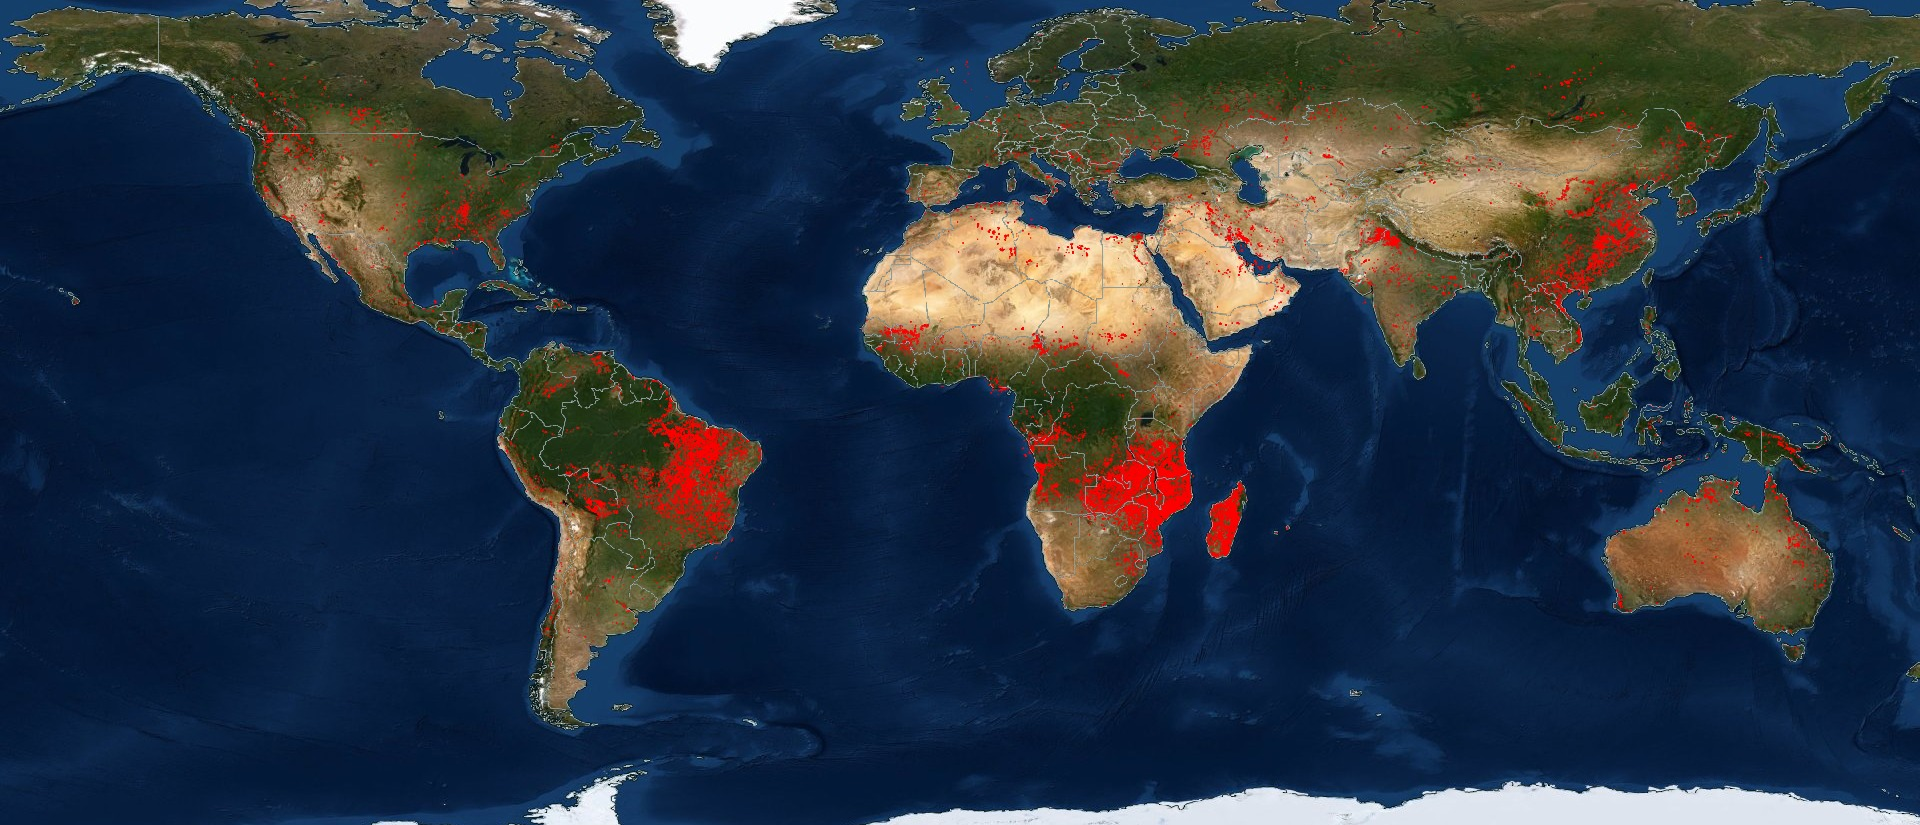

In [19]:
#Считаем картинку и положим значения rgb пикселей в массив numpy
img = Image.open('FIRMS_24hrs_2022-10-18.jpg')
arr = np.asarray(img, dtype='int16')

In [20]:
# Размер картинки 1920х825 пикселей
img.size

(1920, 825)

In [21]:
arr[0]

array([[ 20,  63, 106],
       [ 20,  63, 106],
       [ 20,  63, 106],
       ...,
       [ 17,  65, 103],
       [ 17,  65, 105],
       [ 17,  65, 105]], dtype=int16)

Получили массив размером 1920х825 , где каждый элемент массива является массивом из трех значений RGB модели пикселя

In [22]:
# Считаем значения пикселей в список.
pixels = []
for i in range(img.size[1]):
    for j in range(img.size[0]):
        pixels.append(arr[i][j])

In [23]:
# Преобразуем список в DataFrame для дальнейшей удобной работы с данными
# Длина df должна получиться 1920*825, где каждая строка данных представляет собой значение цветов RGB модели
df = pd.DataFrame(data = pixels, columns = ['red', 'green', 'blue'])
df

,red,green,blue
0,20,63,106
1,20,63,106
2,20,63,106
3,20,63,106
4,20,63,106
...,...,...,...
1583995,218,221,230
1583996,238,242,253
1583997,231,235,246
1583998,221,225,236


При взаимодействии с областью 'пожаров' на картинке можно заметить, что в оттенках красного цвета красный цвет в RGB модели должен быть в +-1.8 раз больше чем любой из двух других, чтобы области пустыни не были помечены как пожары.

In [24]:
# Построим булеву маску, где будем проверять наши условия
(df['red'] > df['green'] * 1.8) & (df['red'] > df['blue'] * 1.8)

0          False
1          False
2          False
3          False
4          False
           ...  
1583995    False
1583996    False
1583997    False
1583998    False
1583999    False
Length: 1584000, dtype: bool

In [25]:
# Взяв среднее, получаем что нашему условию удовлетворяет всего лишь 2.4% от всех пикселей с учетом того,
# что мы брали во внимание не только сушу, но и океаны, т.е вся область картинки.
np.mean((df['red'] > df['green']* 1.8) & (df['red'] > df['blue']* 1.8))

0.024379419191919192

In [26]:
# Попробуем подобрать коэффициент scaler эмперическим путем. Возьмем scaler от 1 до 2.5 с шагом 0.1
[np.mean((df['red'] > df['green']* scaler) & (df['red'] > df['blue']* scaler))
                 for scaler in np.arange(1, 2.5, 0.1)]

[0.16682954545454545,
 0.1347304292929293,
 0.09280113636363636,
 0.05573737373737374,
 0.04150757575757576,
 0.03468497474747475,
 0.029622474747474748,
 0.02650189393939394,
 0.024379419191919192,
 0.02276199494949495,
 0.021287247474747476,
 0.020212752525252526,
 0.019186237373737373,
 0.018310606060606062,
 0.01748989898989899]

In [27]:
# Получили результаты. Видно что для scaler равного 1 наша модель выходит слишком чувствительна
# и почти 17% карты помечаются как пожары. С увеличением scaler чувствительность уменьшается,
# при этом скорость уменьшения value падает после значения scaler 1.3
df_scaler = pd.Series([np.mean((df['red'] > df['green']* scaler) & (df['red'] > df['blue']* scaler))
                 for scaler in np.arange(1, 2.5, 0.1)]).to_frame().rename(columns = { 0 : 'value'})
df_scaler['scaler'] = np.arange(1, 2.5, 0.1)
df_scaler

,value,scaler
0,0.166830,1.0
1,0.134730,1.1
2,0.092801,1.2
3,0.055737,1.3
4,0.041508,1.4
5,0.034685,1.5
6,0.029622,1.6
7,0.026502,1.7
8,0.024379,1.8
9,0.022762,1.9


Для текущего значения value возьмем следующее и разделим их, чтобы посмотреть насколько сильно отличаются результаты.
Когда прирост перестанет резко уменьшаться, то значение для scaler и оставим

In [28]:
df_scaler['value_lag'] = df_scaler['value'].shift(-1)
df_scaler

,value,scaler,value_lag
0,0.166830,1.0,0.134730
1,0.134730,1.1,0.092801
2,0.092801,1.2,0.055737
3,0.055737,1.3,0.041508
4,0.041508,1.4,0.034685
5,0.034685,1.5,0.029622
6,0.029622,1.6,0.026502
7,0.026502,1.7,0.024379
8,0.024379,1.8,0.022762
9,0.022762,1.9,0.021287


In [29]:
df_scaler['growth_rate'] = (df_scaler['value'] / df_scaler['value_lag']) - 1
df_scaler

,value,scaler,value_lag,growth_rate
0,0.166830,1.0,0.134730,0.238247
1,0.134730,1.1,0.092801,0.451819
2,0.092801,1.2,0.055737,0.664971
3,0.055737,1.3,0.041508,0.342824
4,0.041508,1.4,0.034685,0.196702
5,0.034685,1.5,0.029622,0.170901
6,0.029622,1.6,0.026502,0.117749
7,0.026502,1.7,0.024379,0.087060
8,0.024379,1.8,0.022762,0.071058
9,0.022762,1.9,0.021287,0.069278


In [30]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

<AxesSubplot:xlabel='scaler'>

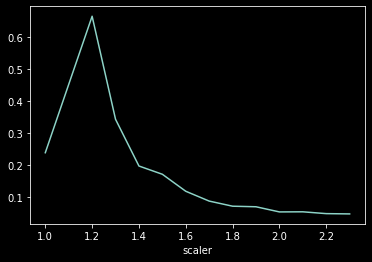

In [31]:
df_scaler.set_index('scaler')['growth_rate'].plot()

Действительно, после значения  scaler  в 1.8 чувствительность метки оттенка цвета как пожара особо не изменяется. Поэтому оставим scaler равным 1.8

In [32]:
df['fire_flag'] = (df['red'] > df['green']* 1.8) & (df['red'] > df['blue']* 1.8)
df

,red,green,blue,fire_flag
0,20,63,106,False
1,20,63,106,False
2,20,63,106,False
3,20,63,106,False
4,20,63,106,False
...,...,...,...,...
1583995,218,221,230,False
1583996,238,242,253,False
1583997,231,235,246,False
1583998,221,225,236,False


In [39]:
# мы получили 38617 пикселей помеченных как пожар
df[df['fire_flag'] == True]

,red,green,blue,fire_flag
51290,112,54,34,True
51291,129,50,37,True
51292,133,48,41,True
51293,134,68,56,True
53210,117,54,37,True
...,...,...,...,...
1244035,109,41,32,True
1245956,117,60,40,True
1245957,112,55,38,True
1247877,119,63,40,True


Попробуем оценить площадь острова в пикселях с помощью симмуляций Монте-Карло.

In [33]:
from tqdm.notebook import tqdm

In [34]:
df

,red,green,blue,fire_flag
0,20,63,106,False
1,20,63,106,False
2,20,63,106,False
3,20,63,106,False
4,20,63,106,False
...,...,...,...,...
1583995,218,221,230,False
1583996,238,242,253,False
1583997,231,235,246,False
1583998,221,225,236,False


In [38]:
df['fire_flag'].value_counts()[True] / df['fire_flag'].value_counts().sum()

0.024379419191919192

In [52]:
# Так как картинка качественная и общее число пикселей составляет больше 1.5 млн то
# нам необходимо брать большие размеры подвыборок
# Попробуем взять подвыборки с возвращением размером от 500 наблюдений до 10млн.
# и посмотреть на точность результатов
sample_size = [500, 1000, 10000, 50000, 500000, 1000000, 5000000, 10000000]
result = []

for n in tqdm(sample_size):
    simmulation = df['fire_flag'].sample(n , replace = True).value_counts()
    result.append(simmulation[True]/simmulation.sum())

  0%|          | 0/8 [00:00<?, ?it/s]

In [53]:
result

[0.034, 0.018, 0.0272, 0.02322, 0.0245, 0.024125, 0.0244666, 0.0243702]

In [54]:
df_simmulation = pd.Series(sample_size).to_frame().rename(columns = {0: 'sample_size'})
df_simmulation['square'] = pd.Series(result).values

In [55]:
# Начиная с размера подвыборки в 50тыс. имеем довольно точные результаты
# Подвыборка с размером в 10млн. позволила определить площадь с точностью до 5го знака
df_simmulation

,sample_size,square
0,500,0.034000
1,1000,0.018000
2,10000,0.027200
3,50000,0.023220
4,500000,0.024500
5,1000000,0.024125
6,5000000,0.024467
7,10000000,0.024370


In [58]:
# Получили значение в 0.02437 от всей картинки. Умножим на общее число пикселей(1920*825)
round(0.024370*1920*825)

38602

Получили 38602 пикселся с помощью симмуляций. А всего как очаги огня мы пометили 38617 пикселей.